# TOG Attacks on YOLOv3 (Darknet53)

This jupyter notebook demonstrate the use of TOG attacks on one of the state-of-the-art object detection algorithms: You Only Look Once v3 (YOLOv3) proposed by Joseph Redmon [[link]](https://pjreddie.com/media/files/papers/YOLOv3.pdf). It has a Darknet53 backbone architecture. More details on the adversarial attacks can be found in the papers listed in the repository [[link]](https://github.com/git-disl/TOG).

## Preparation of Victim Detector

In [ ]:
from dataset_utils.preprocessing import letterbox_image_padded
from misc_utils.visualization import visualize_detections
from keras import backend as K
from models.yolov3 import YOLOv3_Darknet53
from PIL import Image
from tog.attacks import *
import os
K.clear_session()

You can download the pretrained weights here [[link]](https://github.com/git-disl/TOG/releases/download/pm-v1.0/YOLOv3_Darknet53.h5) or use the popular repository implementing YOLOv3 in Keras [[link]](https://github.com/qqwweee/keras-yolo3) to train your own model. Once you have downloaded or trained the YOLOv3 detector, you need to *modify* the path in the cell below to point to the `.h5` file. 

In [ ]:
weights = 'model_weights/YOLOv3_Darknet53.h5'  # TODO: Change this path to the victim model's weights

detector = YOLOv3_Darknet53(weights=weights)

## Configuration of Attack Hyperparameters

In [4]:
eps = 8 / 255.       # Hyperparameter: epsilon in L-inf norm
eps_iter = 2 / 255.  # Hyperparameter: attack learning rate
n_iter = 10          # Hyperparameter: number of attack iterations

We then load and visualize the image to be attacked using TOG algorithms.

<Figure size 432x288 with 0 Axes>

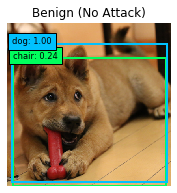

In [5]:
fpath = './assets/example_1.jpg'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes)})

## TOG-untargeted Attack

Random untargeted attacks fool the victim detector to randomly misdetect without targeting at any specific object. This class of attacks succeeds if the adversarial example fools the victim detector to give incorrect results of any form, such as having objects vanished, fabricated, or mislabeled randomly.

<Figure size 432x288 with 0 Axes>

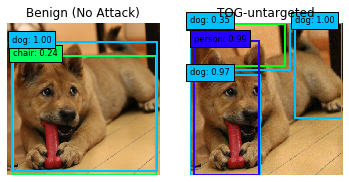

In [6]:
# Generation of the adversarial example
x_adv_untargeted = tog_untargeted(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_untargeted = detector.detect(x_adv_untargeted, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-untargeted': (x_adv_untargeted, detections_adv_untargeted, detector.model_img_size, detector.classes)})

## TOG-vanishing Attack

Having a high recall to retrieve the objects in the input image is crucial in many applications. For instance, object detection has been applied in radiology to conduct automated breast cancer diagnosis, and positive detection alarms the patient to receive a further medical examination by a human expert. TOG-vanishing aims at removing the victim's ability to identify objects (i.e., adding false negatives). 

<Figure size 432x288 with 0 Axes>

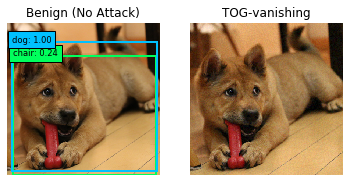

In [7]:
# Generation of the adversarial example
x_adv_vanishing = tog_vanishing(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-vanishing': (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes)})

## TOG-fabrication Attack

Different from the above, the TOG-fabrication attack fabricates additional detections (i.e., adding false positives).

<Figure size 432x288 with 0 Axes>

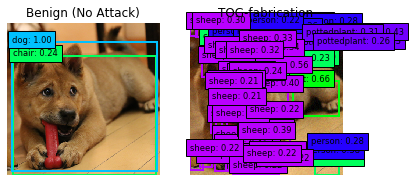

In [8]:
x_adv_fabrication = tog_fabrication(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_fabrication = detector.detect(x_adv_fabrication, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-fabrication': (x_adv_fabrication, detections_adv_fabrication, detector.model_img_size, detector.classes)})

## TOG-mislabeling Attack

This attack consistently causes the victim detector to misclassify the objects detected on the input image by replacing their source class label with the maliciously chosen target class label, while maintaining the same set of correct bounding boxes. Such an attack can cause fatal collisions in many scenarios, e.g., misclassifying the stop sign as an umbrella. We can conduct the most-likely (ML) class attack by setting the attack targets to the incorrect class label with the highest probability predicted by the victim or the least-likely (LL) class attack with the lowest probability.

<Figure size 432x288 with 0 Axes>

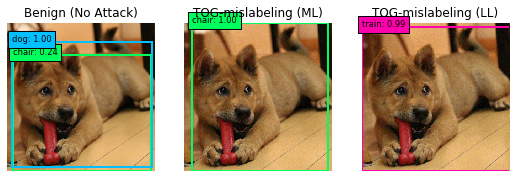

In [9]:
# Generation of the adversarial examples
x_adv_mislabeling_ml = tog_mislabeling(victim=detector, x_query=x_query, target='ml', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
x_adv_mislabeling_ll = tog_mislabeling(victim=detector, x_query=x_query, target='ll', n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial examples and compare them with that on the benign input
detections_adv_mislabeling_ml = detector.detect(x_adv_mislabeling_ml, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ll = detector.detect(x_adv_mislabeling_ll, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (ML)': (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (LL)': (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes)})